## **Read datasets**

In [0]:
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def read_datasets() -> DataFrame:
    restaurant = spark.table("workspace.default.restaurant")
    consumer = spark.table("workspace.default.consumer")
    order1 = spark.table("workspace.default.order_parte_1")
    order2 = spark.table("workspace.default.order_parte_2")
    order = order1.union(order2)
    ab = spark.table("workspace.default.ab_test_ref")
    return restaurant, consumer, order, ab
#restaurant_df.show()
# restaurant_df.count()
# for df, name in [(restaurant_df, "order")]:
#     print(f"\n===> {name}")
#     df.select([sf.countDistinct(sf.col(c)).alias(c) for c in df.columns]).show()
#     df.describe().show()

In [0]:
restaurant, consumer, order, ab = read_datasets()

## **Qualidade dos dados**
#### - count nulos
#### - describe pra entender a distribuição dos dados

In [0]:
from pyspark.sql import functions as sf

for df, name in [(restaurant, "restaurants"), (consumer,"consumers"),(ab,"ab"),(order,"order")]:
    print(f"--- {name} ---")
    exprs = [sf.sum(sf.col(c).isNull().cast("int")).alias(c) for c in df.columns]
    df.agg(*exprs).show()
    df.describe().show()
    df.printSchema()

--- restaurants ---
+---+----------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+-------------+--------------+----------------+
| id|created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code|merchant_city|merchant_state|merchant_country|
+---+----------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+-------------+--------------+----------------+
|  0|         0|      0|          0|             0|           0|            1|                 95|                0|            0|             0|               0|
+---+----------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+-------------+--------------+----------------+

+-------+--------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+-------------+------

In [0]:
restaurant_ = restaurant.filter(sf.col('minimum_order_value')> 100)
restaurant_.count()

2

## **Processamento dados**

In [0]:
# Processar pedidos
orders_processed = order.select(
    sf.col("order_id"),
    sf.col("customer_id"),
    sf.col("merchant_id"),
    sf.col("order_created_at").cast("timestamp"),
    sf.col("order_total_amount").cast("float"),
    sf.col("order_scheduled").cast("boolean"),
    sf.col('delivery_address_state').alias('delivery_address_state'),
    sf.to_date(sf.col("order_created_at")).alias("order_date"),
    sf.month(sf.col("order_created_at")).alias("order_month"),
    sf.dayofweek(sf.col("order_created_at")).alias("order_dayofweek"),
    sf.hour(sf.col("order_created_at")).alias("order_hourofday")
).filter(sf.col("order_total_amount").isNotNull() & (sf.col("order_total_amount") > 0))

# Processar usuários
consumers_processed = consumer.select(
    sf.col("customer_id"),
    sf.col("created_at").cast("timestamp"),
    sf.col("active").cast("boolean"),
    sf.to_date(sf.col("created_at")).alias("signup_date"),
    sf.datediff(sf.current_date(), sf.col("created_at")).alias("days_since_signup")
)

# Processar restaurantes
restaurants_processed = restaurant.select(
    sf.col("id").alias("merchant_id"),
    sf.col("price_range"),
    sf.col("average_ticket"),
    sf.col("delivery_time"),
    sf.col("minimum_order_value"),
    sf.col("merchant_city"),
    sf.col("merchant_state")
)

# Processar teste A/B
ab_test_processed = ab.select(
    sf.col("customer_id"),
    sf.col("is_target").alias("test_group")
)

## **Joins**

In [0]:
# Criar dataset completo
full_data = orders_processed.join(
    consumers_processed, "customer_id", "left"
).join(
    restaurants_processed, "merchant_id", "left"
).join(
    ab_test_processed, "customer_id", "left"
)

# Adicionar flag para usuários no teste
full_data = full_data.withColumn(
    "in_test", 
    sf.when(sf.col("test_group").isNotNull(), True).otherwise(False))

In [0]:
orders_processed.count()

774989

In [0]:
full_data.count()

774989

In [0]:
full_data.distinct().count()

774989

## **Analises**

In [0]:
# Calcular métricas por grupo
ab_test_metrics = (full_data.filter(sf.col("in_test")).groupBy("test_group").agg(
    sf.countDistinct("customer_id").alias("unique_users"),
    sf.count("order_id").alias("total_orders"),
    sf.avg("order_total_amount").alias("avg_order_value"),
    sf.sum("order_total_amount").alias("total_revenue"),
    sf.countDistinct(sf.when(sf.col("order_id").isNotNull(), sf.col("customer_id"))).alias("retained_users")
).withColumn(
    "retention_rate", sf.col("retained_users") / sf.col("unique_users")
).withColumn(
    "orders_per_user", sf.col("total_orders") / sf.col("unique_users")
).withColumn(
    "revenue_per_user", sf.col("total_revenue") / sf.col("unique_users")
)
)

# Mostrar resultados
ab_test_metrics.show()

+----------+------------+------------+------------------+--------------------+--------------+--------------+------------------+-----------------+
|test_group|unique_users|total_orders|   avg_order_value|       total_revenue|retained_users|retention_rate|   orders_per_user| revenue_per_user|
+----------+------------+------------+------------------+--------------------+--------------+--------------+------------------+-----------------+
|   control|      176883|      321694|48.013583510429086|1.5445681733803974E7|        176883|           1.0|1.8186824058841156|87.32145957386507|
|    target|      235370|      451629| 48.01827736061565|2.1686446586097486E7|        235370|           1.0|1.9188044355695288| 92.1376835879572|
+----------+------------+------------+------------------+--------------------+--------------+--------------+------------------+-----------------+



In [0]:
def calculate_significance(full_data, group_a, group_b, metric):
    """
    Função aprimorada para cálculo de significância estatística e comparação de grupos
    
    Parâmetros:
    full_data: DataFrame Spark contendo os dados
    group_a: Nome do grupo A (ex: "target")
    group_b: Nome do grupo B (ex: "control")
    metric: Métrica a ser testada ("order_sum_per_user", "orders_per_user", "order_total_amount")
    Retorna:
    Dicionário com resultados estatísticos e comparação entre grupos
    """
    from pyspark.sql import functions as sf

    # Calcular métricas e estatísticas descritivas
    if metric == "order_sum_per_user":
        df = full_data.filter(sf.col("in_test")).groupBy("test_group", "customer_id").agg(
            sf.sum("order_total_amount").alias("order_sum_per_user")
        )
        pdf = df.toPandas()
        group_a_data = pdf[pdf['test_group'] == group_a]['order_sum_per_user']
        group_b_data = pdf[pdf['test_group'] == group_b]['order_sum_per_user']
        
    elif metric == "orders_per_user":
        df = full_data.filter(sf.col("in_test")).groupBy("test_group", "customer_id").agg(
            sf.count("order_id").alias("orders_per_user")
        )
        pdf = df.toPandas()
        group_a_data = pdf[pdf['test_group'] == group_a]['orders_per_user']
        group_b_data = pdf[pdf['test_group'] == group_b]['orders_per_user']
        
    elif metric == "order_total_amount":
        df = full_data.filter(sf.col("in_test")).select("test_group", "order_total_amount")
        pdf = df.toPandas()
        group_a_data = pdf[pdf['test_group'] == group_a]['order_total_amount']
        group_b_data = pdf[pdf['test_group'] == group_b]['order_total_amount']
    
    # Teste t
    t_stat, p_val = stats.ttest_ind(group_a_data, group_b_data, equal_var=False)
    
    # Calcular estatísticas descritivas
    mean_a = group_a_data.mean()
    mean_b = group_b_data.mean()
    count_a = len(group_a_data)
    count_b = len(group_b_data)
    
    # Determinar qual grupo é maior/menor
    comparison = ""
    if mean_a > mean_b:
        comparison = f"{group_a} > {group_b} (Diferença: {mean_a - mean_b:.2f})"
    elif mean_a < mean_b:
        comparison = f"{group_a} < {group_b} (Diferença: {mean_b - mean_a:.2f})"
    else:
        comparison = f"{group_a} = {group_b}"
    
    return {
        "t_statistic": t_stat,
        "p_value": p_val,
        f"mean_{group_a}": mean_a,
        f"mean_{group_b}": mean_b,
        f"count_{group_a}": count_a,
        f"count_{group_b}": count_b,
        "comparison": comparison
    }

# Testar métricas
metrics_to_test = ["order_sum_per_user", "orders_per_user", "order_total_amount"]
results = {}

for metric in metrics_to_test:
    results[metric] = calculate_significance(full_data, "target", "control", metric)

# Exibir resultados detalhados
print("Resultados dos testes de significância:")
for metric, result in results.items():
    print(f"\nMétrica: {metric}")
    print(f"Estatística t: {result['t_statistic']:.4f}")
    print(f"Valor p: {result['p_value']:.4f}")
    print(f"Média {result['comparison']}")
    print(f"Detalhes:")
    print(f"- Média {result['mean_target']:.2f} (target, n={result['count_target']})")
    print(f"- Média {result['mean_control']:.2f} (control, n={result['count_control']})")
    if result['p_value'] < 0.05:
        print("CONCLUSÃO: Diferença estatisticamente significativa (p < 0.05)")
    else:
        print("CONCLUSÃO: Diferença NÃO significativa")

Resultados dos testes de significância:

Métrica: order_sum_per_user
Estatística t: 11.9051
Valor p: 0.0000
Média target > control (Diferença: 4.82)
Detalhes:
- Média 92.14 (target, n=235370)
- Média 87.32 (control, n=176883)
CONCLUSÃO: Diferença estatisticamente significativa (p < 0.05)

Métrica: orders_per_user
Estatística t: 19.2215
Valor p: 0.0000
Média target > control (Diferença: 0.10)
Detalhes:
- Média 1.92 (target, n=235370)
- Média 1.82 (control, n=176883)
CONCLUSÃO: Diferença estatisticamente significativa (p < 0.05)

Métrica: order_total_amount
Estatística t: 0.0313
Valor p: 0.9750
Média target > control (Diferença: 0.00)
Detalhes:
- Média 48.02 (target, n=451629)
- Média 48.01 (control, n=321694)
CONCLUSÃO: Diferença NÃO significativa


In [0]:
# Calcular impacto financeiro
financial_impact = full_data.filter(
    (sf.col("in_test")) & (sf.col("test_group") == "target")
).agg(
    (sf.sum("order_total_amount") * 0.2 - sf.sum("order_total_amount") * 0.1).alias("net_profit"),
    sf.countDistinct("customer_id").alias("target_users")
).withColumn(
    "profit_per_user", sf.col("net_profit") / sf.col("target_users")
).withColumn(
    "roi", (sf.col("net_profit") - (sf.col("target_users") * 50)) / (sf.col("target_users") * 50)
)
financial_impact.show()

+-----------------+------------+----------------+-------------------+
|       net_profit|target_users| profit_per_user|                roi|
+-----------------+------------+----------------+-------------------+
|2168644.658609749|      235370|9.21376835879572|-0.8157246328240857|
+-----------------+------------+----------------+-------------------+



In [0]:
from pyspark.sql.window import Window

# Primeiro, calcular métricas de comportamento por usuário
user_behavior = full_data.groupBy("customer_id").agg(
    sf.count("order_id").alias("order_count"),
    sf.sum("order_total_amount").alias("total_spend"),
    sf.avg("order_total_amount").alias("avg_order_value"),
    sf.max("order_created_at").alias("last_order_date"),
    sf.min("order_created_at").alias("first_order_date"),
    sf.countDistinct("merchant_id").alias("unique_restaurants")
)

# Calcular recência (dias desde a última compra)
user_behavior = user_behavior.withColumn(
    "recency",
    sf.datediff(sf.lit("2019-02-01"), sf.col("last_order_date"))  # Assumindo final do período em jan/2019
)

# Definir segmentos baseados no comportamento
segments = user_behavior.withColumn(
    "user_segment_order",
    sf.when((sf.col("order_count") >= 1) & (sf.col("order_count") <= 5), "low_user")
    .when((sf.col("order_count") > 5) & (sf.col("order_count") <= 10), "medium_user")
    .when((sf.col("order_count") > 10), "ultra_user")
    .otherwise("regular_user")
)

segments_value = user_behavior.withColumn(
    "user_segment_order_value",
    sf.when((sf.col("avg_order_value") >= 1) & (sf.col("order_count") <= 30), "low_spender")
    .when((sf.col("avg_order_value") > 30) & (sf.col("avg_order_value") <= 100), "medium_spender")
    .when((sf.col("avg_order_value") > 100), "ultra_spender")
    .otherwise("regular_user")
)

# Juntar com os dados originais
full_data_segmented = full_data.join(
    segments.select("customer_id", "user_segment_order"), 
    "customer_id", 
    "left"
)

full_data_segmented_spend = full_data.join(
    segments_value.select("customer_id", "user_segment_order_value"), 
    "customer_id", 
    "left"
)

In [0]:
 #Análise de desempenho por segmento
from statsmodels.stats.proportion import proportions_ztest
segment_performance = full_data_segmented.groupBy("test_group", "user_segment_order").agg(
   sf.countDistinct("customer_id").alias("users"),
    sf.count("order_id").alias("orders"),
    sf.sum("order_total_amount").alias("revenue"),
    sf.avg("order_total_amount").alias("avg_order_value"),
    sf.try_divide(sf.count("order_id") ,sf.countDistinct("customer_id")).alias("orders_per_user")
).orderBy("user_segment_order", "test_group")

# Teste de significância por segmento
for segment in ["low_user", "medium_user", "ultra_user"]:
    segment_data = full_data_segmented.filter(sf.col("user_segment_order") == segment)
    
    if segment_data.count() > 0:
        conversion_segment = segment_data.groupBy("test_group").agg(
            sf.countDistinct("customer_id").alias("total_users"),
            sf.countDistinct(sf.when(sf.col("order_id").isNotNull(), "customer_id")).alias("converted_users")
        ).collect()
        
        if len(conversion_segment) == 2:
            target = conversion_segment[0] if conversion_segment[0]["test_group"] == "target" else conversion_segment[1]
            control = conversion_segment[1] if conversion_segment[1]["test_group"] == "control" else conversion_segment[0]
            
            count = [target["converted_users"], control["converted_users"]]
            nobs = [target["total_users"], control["total_users"]]
            
            if nobs[0] > 0 and nobs[1] > 0:
                z_stat, p_value = proportions_ztest(count, nobs)
                print(f"Segmento {segment}: Z-score = {z_stat:.2f}, p-value = {p_value:.4f}")

Segmento low_user: Z-score = -0.20, p-value = 0.8419
Segmento medium_user: Z-score = -0.28, p-value = 0.7791
Segmento ultra_user: Z-score = -0.30, p-value = 0.7676


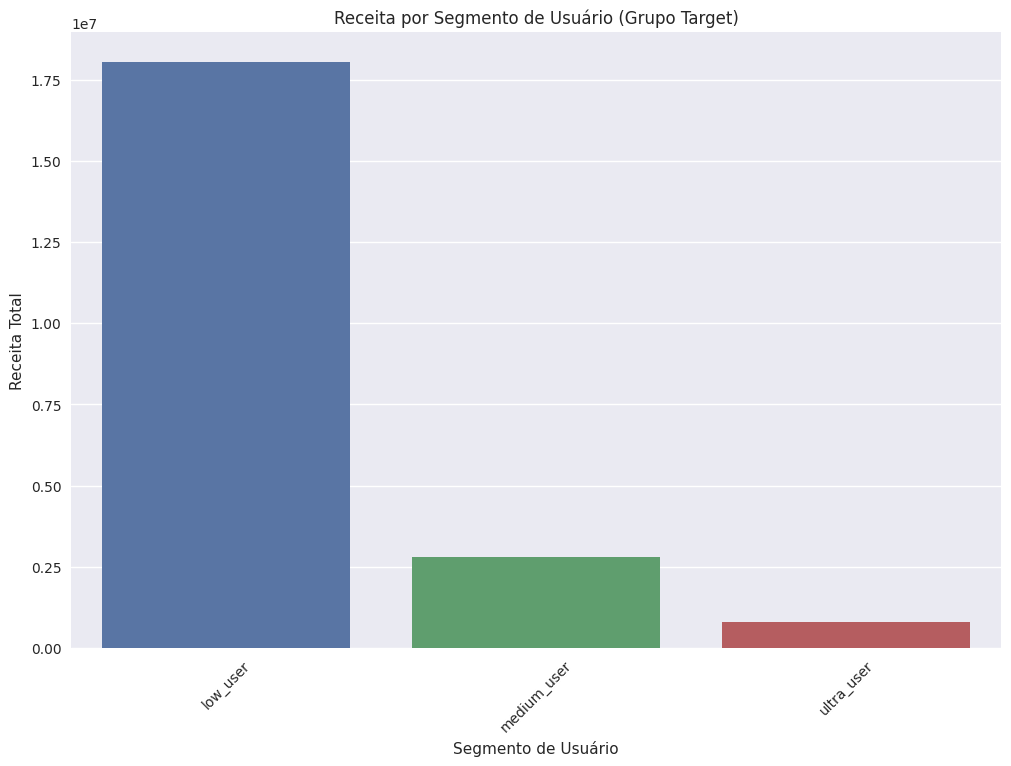

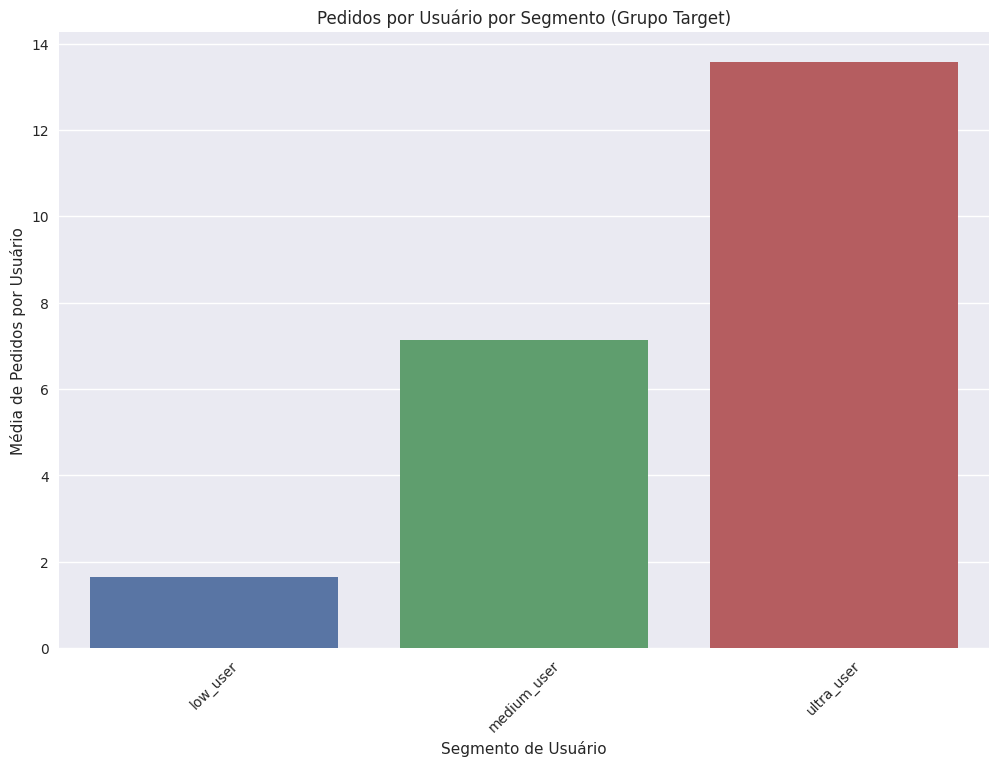

In [0]:
# Converter para Pandas para visualização
segment_pd = segment_performance.toPandas()

# Filtrar apenas grupo de tratamento para simplificar
treatment_segments = segment_pd[segment_pd["test_group"] == "target"]

plt.figure(figsize=(12, 8))
sns.barplot(x="user_segment", y="revenue", data=treatment_segments, 
            order=["low_user", "medium_user", "ultra_user"])
plt.title("Receita por Segmento de Usuário (Grupo Target)")
plt.ylabel("Receita Total")
plt.xlabel("Segmento de Usuário")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x="user_segment", y="orders_per_user", data=treatment_segments,
            order=["low_user", "medium_user", "ultra_user"])
plt.title("Pedidos por Usuário por Segmento (Grupo Target)")
plt.ylabel("Média de Pedidos por Usuário")
plt.xlabel("Segmento de Usuário")
plt.xticks(rotation=45)
plt.show()

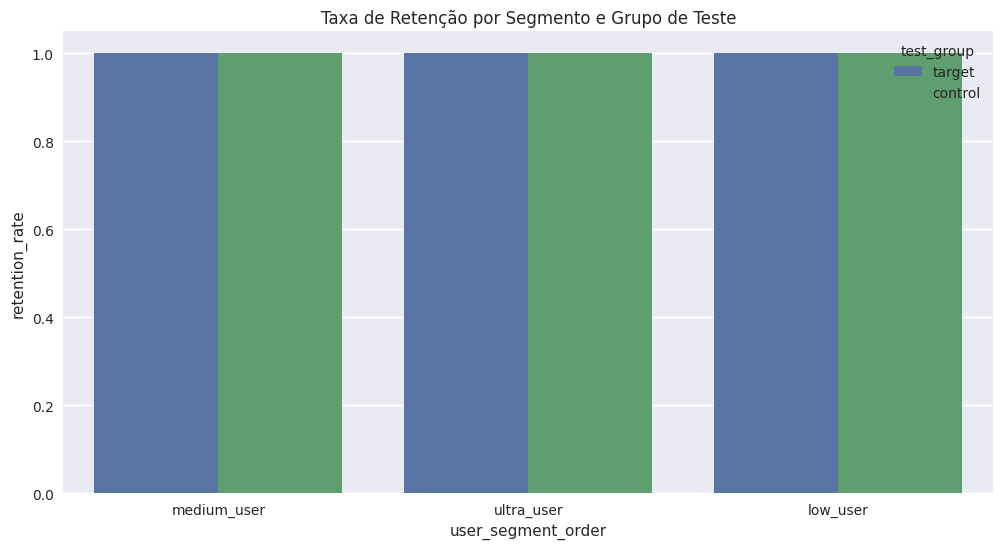

In [0]:
segment_metrics = full_data_segmented.filter(sf.col("in_test")).groupBy(
    "user_segment_order", "test_group"
).agg(
    sf.countDistinct("customer_id").alias("unique_users"),
    sf.count("order_id").alias("total_orders"),
    sf.avg("order_total_amount").alias("avg_order_value"),
    sf.sum("order_total_amount").alias("total_revenue"),
    sf.countDistinct(sf.when(sf.col("order_id").isNotNull(), sf.col("customer_id"))).alias("retained_users")
).withColumn(
    "retention_rate", sf.col("retained_users") / sf.col("unique_users")
).withColumn(
    "orders_per_user", sf.col("total_orders") / sf.col("unique_users")
).withColumn(
    "revenue_per_user", sf.col("total_revenue") / sf.col("unique_users")
)

# Visualizar resultados
segment_metrics_pd = segment_metrics.toPandas()

# Gráfico de retenção por segmento
plt.figure(figsize=(12, 6))
sns.barplot(x="user_segment_order", y="retention_rate", hue="test_group", data=segment_metrics_pd)
plt.title("Taxa de Retenção por Segmento e Grupo de Teste")
plt.show()

<Figure size 1400x800 with 0 Axes>

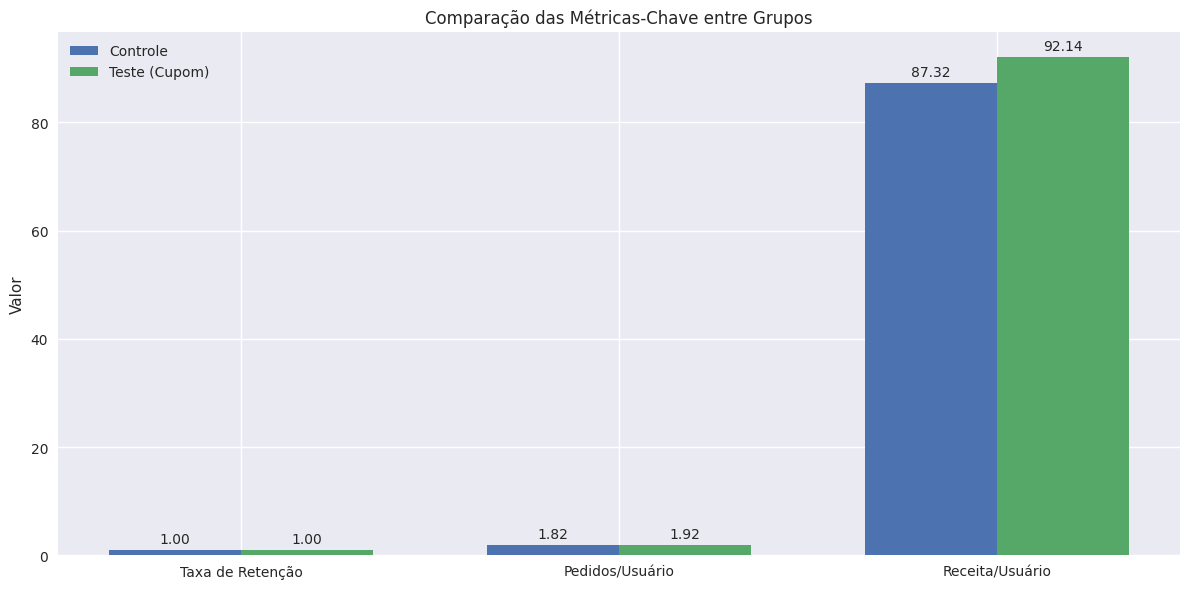

In [0]:
# Coletar métricas para visualização
ab_test_pd = ab_test_metrics.toPandas()

# Configurar o estilo
plt.style.use('seaborn')
plt.figure(figsize=(14, 8))

# Gráfico de barras comparativo
metrics_to_plot = ['retention_rate', 'orders_per_user', 'revenue_per_user']
x = np.arange(len(metrics_to_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, ab_test_pd[ab_test_pd['test_group'] == 'control'][metrics_to_plot].values.flatten(), 
                width, label='Controle')
rects2 = ax.bar(x + width/2, ab_test_pd[ab_test_pd['test_group'] == 'target'][metrics_to_plot].values.flatten(), 
                width, label='Teste (Cupom)')

ax.set_ylabel('Valor')
ax.set_title('Comparação das Métricas-Chave entre Grupos')
ax.set_xticks(x)
ax.set_xticklabels(['Taxa de Retenção', 'Pedidos/Usuário', 'Receita/Usuário'])
ax.legend()

# Adicionar valores nas barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

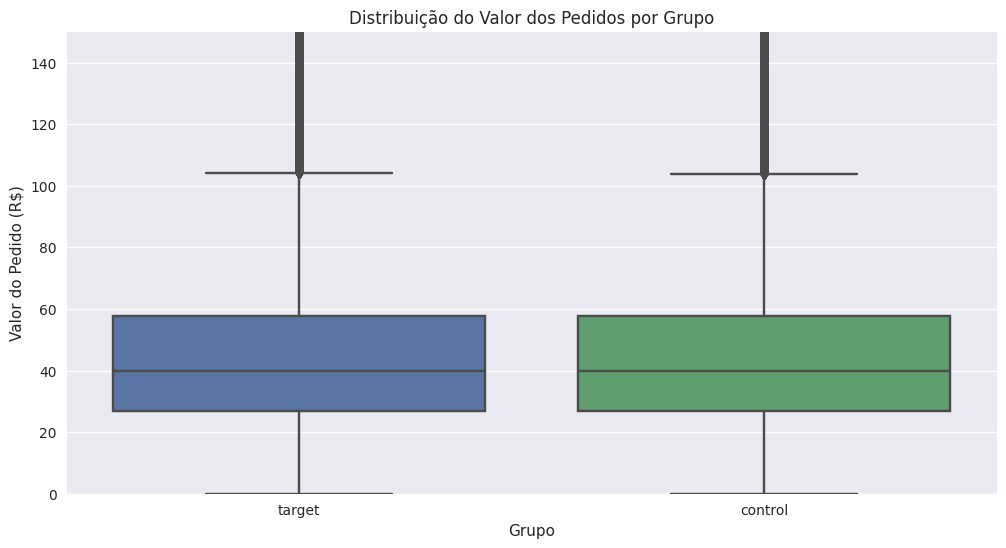

In [0]:
# Preparar dados
order_values_pd = full_data.filter(sf.col("in_test")).select(
    "test_group", "order_total_amount"
).toPandas()

# Plotar distribuição
plt.figure(figsize=(12, 6))
sns.boxplot(x='test_group', y='order_total_amount', data=order_values_pd)
plt.ylim(0, 150)  # Limitando para melhor visualização
plt.title('Distribuição do Valor dos Pedidos por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Valor do Pedido (R$)')
plt.show()

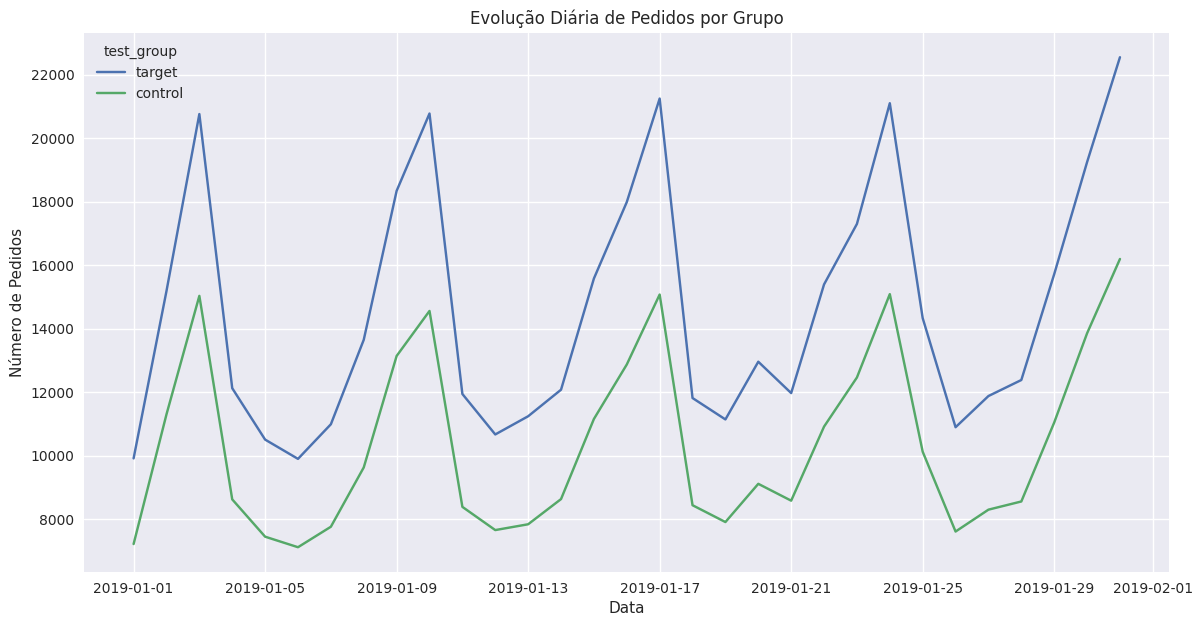

In [0]:
# Pedidos por dia e grupo
daily_orders = full_data.filter(sf.col("in_test")).groupBy(
    "order_date", "test_group"
).agg(
    sf.count("order_id").alias("order_count")
).orderBy("order_date").toPandas()

# Plotar série temporal
plt.figure(figsize=(14, 7))
sns.lineplot(x='order_date', y='order_count', hue='test_group', 
             data=daily_orders, ci=None)
plt.title('Evolução Diária de Pedidos por Grupo')
plt.xlabel('Data')
plt.ylabel('Número de Pedidos')
plt.grid(True)
plt.show()

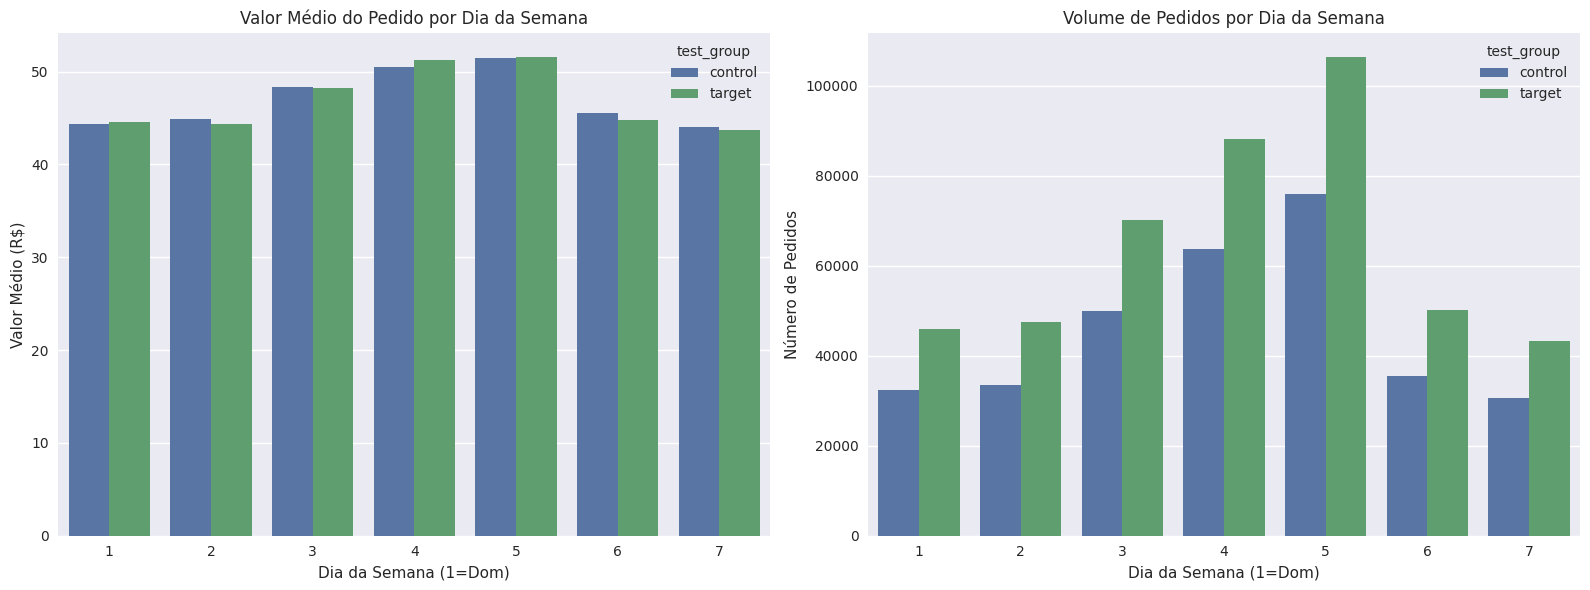

In [0]:
# Pedidos por dia da semana
weekday_orders = full_data.filter(sf.col("in_test")).groupBy(
    "order_dayofweek", "test_group"
).agg(
    sf.avg("order_total_amount").alias("avg_order_value"),
    sf.count("order_id").alias("order_count")
).orderBy("order_dayofweek").toPandas()

# Plotar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Valor médio
sns.barplot(x='order_dayofweek', y='avg_order_value', hue='test_group', 
            data=weekday_orders, ax=ax1)
ax1.set_title('Valor Médio do Pedido por Dia da Semana')
ax1.set_xlabel('Dia da Semana (1=Dom)')
ax1.set_ylabel('Valor Médio (R$)')

# Volume
sns.barplot(x='order_dayofweek', y='order_count', hue='test_group', 
            data=weekday_orders, ax=ax2)
ax2.set_title('Volume de Pedidos por Dia da Semana')
ax2.set_xlabel('Dia da Semana (1=Dom)')
ax2.set_ylabel('Número de Pedidos')

plt.tight_layout()
plt.show()